In [1]:
import os
import numpy as np
import cv2
import math
import shutil
import matplotlib.pyplot as plt
from random import randint

In [2]:
def show_images(images, titles=None):
    if not titles:
        titles = [img.shape for img in images]
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 30))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="summer")
        ax.set_title(titles[i])
        ax.axis("off")
    plt.show()

def show_1image(image, size = (4,4)):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=size)
    axes.imshow(image, cmap="summer")
    axes.axis("off")
    plt.show()

In [3]:
root_example_path = r'example_images'
example_image_paths = []

for path in sorted(os.listdir(root_example_path)):
    example_path = os.path.join(root_example_path,path)
    example_image_paths.append(example_path)

In [4]:
example_image_paths

['example_images\\VatSaiKhlongSaphanSung_136_tile_2048_4096.png',
 'example_images\\VatSaiKhlongSaphanSung_136_tile_4608_7680.png',
 'example_images\\VatSaiKhlongSaphanSung_51_tile_9216_3584.png',
 'example_images\\VatSaiKhlongSaphanSung_51_tile_9216_4096.png',
 'example_images\\VatSaiKhlongSaphanSung_7_tile_4608_3584.png',
 'example_images\\village_A10_tile_512_0.png',
 'example_images\\village_A12_tile_2048_1024.png',
 'example_images\\village_A8_tile_0_0.png']

In [9]:
i = randint(0,len(example_image_paths)-1) # Example Image Randomizer

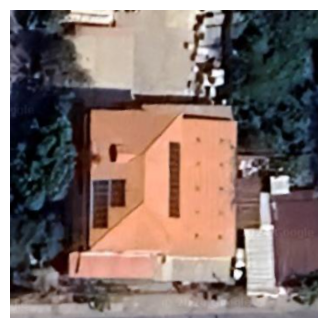

In [10]:
# i = randint(0,len(example_image_paths)-1)

image_og = cv2.imread(example_image_paths[i])
image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
show_1image(image_og)

## Gamma

In [11]:
def gamma_correction(image):

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, sat, val = cv2.split(image_hsv)

    # compute gamma = log(mid*255)/log(mean)
    mid = 0.5
    mean = np.mean(val)
    gamma = math.log(mid*255)/math.log(mean)
    # print(gamma)

    # do gamma correction on value channel
    val_gamma = np.power(val, gamma).clip(0,255).astype(np.uint8)

    # combine new value channel with original hue and sat channels
    gamma_image_hsv = cv2.merge([hue, sat, val_gamma])
    gamma_image = cv2.cvtColor(gamma_image_hsv, cv2.COLOR_HSV2BGR)

    return gamma_image

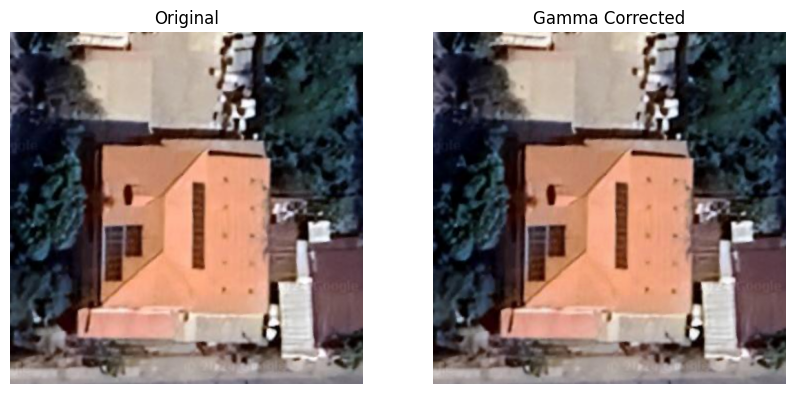

In [12]:
# i = randint(0,len(example_image_paths)-1)
image_og = cv2.imread(example_image_paths[i])
image_gamma_corrected = gamma_correction(image_og)

cv2.imwrite('test_img.png',image_gamma_corrected)

# Compare Image
image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
image_gamma_corrected = cv2.cvtColor(image_gamma_corrected, cv2.COLOR_BGR2RGB)
show_images((image_og, image_gamma_corrected),['Original','Gamma Corrected'])

## Histogram Equalization

In [13]:
def histogram_equalization(image):

    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    l, a, b = cv2.split(image_lab)

    equ = cv2.equalizeHist(l)

    hist_image = cv2.merge((equ,a,b))
    hist_image = cv2.cvtColor(hist_image, cv2.COLOR_LAB2BGR)

    return hist_image

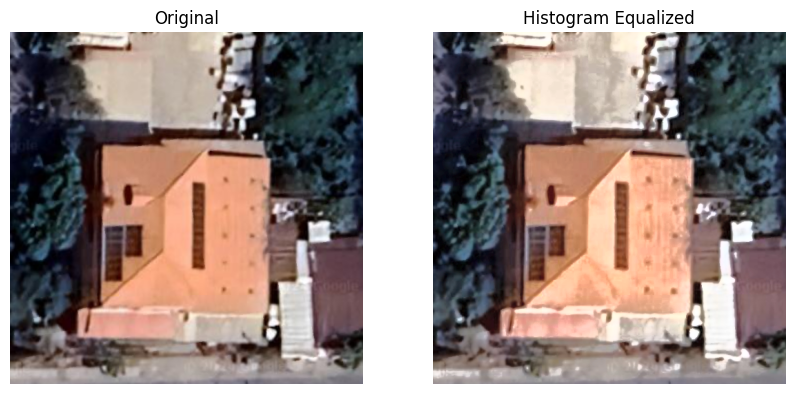

In [14]:
# i = randint(0,len(example_image_paths)-1)
image_og = cv2.imread(example_image_paths[i])

image_histogram_equalization = histogram_equalization(image_og)

cv2.imwrite('test_img.png',image_histogram_equalization)

# Compare Image
image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
image_histogram_equalization = cv2.cvtColor(image_histogram_equalization, cv2.COLOR_BGR2RGB)
show_images((image_og,image_histogram_equalization),['Original','Histogram Equalized'])

## CLAHE

In [15]:
def clahe(image):

    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    clahe = cv2.createCLAHE(clipLimit=2)
    image_lab[...,0] = clahe.apply(image_lab[...,0])

    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
    return image_rgb

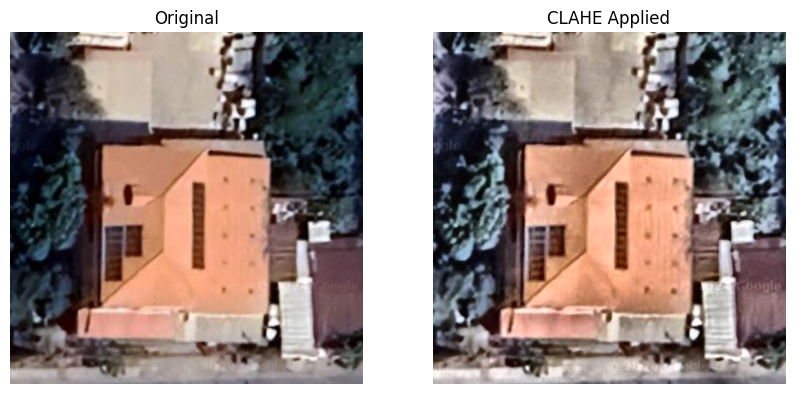

In [16]:
# i = randint(0,len(example_image_paths)-1)
image_og = cv2.imread(example_image_paths[i])

image_clahe = clahe(image_og)

cv2.imwrite('test_img.png',image_clahe)


image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_BGR2RGB)
show_images((image_og,image_clahe),['Original','CLAHE Applied'])

## Apply image enhancement to Dataset

In [17]:
def preprocess_dataset(dataset_path, dataset_out_path, preprocess):
    """
    Preprocesses a dataset of images and their corresponding masks.

    Parameters:
    dataset_path (str): The path to the original dataset directory.
    dataset_out_path (str): The path to the output directory where the preprocessed dataset will be saved.
    preprocess (function): A function that takes an image as input and returns the preprocessed image.

    This function does the following:
    1. Creates the output directory if it does not exist.
    2. Iterates over each subdirectory in the dataset_path.
    3. For each subdirectory, creates a corresponding subdirectory in the output directory.
    4. For each image file (excluding mask files) in the subdirectory:
       a. Reads the image using OpenCV.
       b. Applies the preprocessing function to the image.
       c. Saves the preprocessed image to the corresponding output subdirectory.
       d. Copies the corresponding mask file to the output subdirectory, renaming it to match the output image file format.
    """
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(dataset_out_path):
        os.makedirs(dataset_out_path)

    # Iterate over each subdirectory in the dataset path
    for dir in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir)
        dir_out_path = os.path.join(dataset_out_path, dir)

        # Create the corresponding output subdirectory if it doesn't exist
        if not os.path.exists(dir_out_path):
            os.makedirs(dir_out_path)

        # Iterate over each item in the subdirectory
        for item in os.listdir(dir_path):
            if '_mask' not in item:
                # Construct paths for the image and its mask
                image_path = os.path.join(dir_path, item)
                image_name, image_extension = image_path.split('.')
                mask_path = image_name + '_mask.' + image_extension

                # Read and preprocess the image
                image = cv2.imread(image_path)
                image_preprocessed = preprocess(image)

                # Construct output paths for the preprocessed image and its mask
                image_out_path = os.path.join(dir_out_path, item)
                image_out_name, image_out_extension = image_out_path.split('.')
                mask_out_path = image_out_name + '_mask.' + image_out_extension

                # Save the preprocessed image and copy the mask
                cv2.imwrite(image_out_path, image_preprocessed)
                shutil.copyfile(mask_path, mask_out_path)

In [18]:
dataset_path = r'test_input_dataset'
output_dataset_path = 'test_output_dataset_CLAHE'

preprocess_dataset(dataset_path, output_dataset_path, clahe)


## View output in sub directories

In [19]:
root_path = r'test_output_dataset_CLAHE\VatSaiKhlongSaphanSung_7'
image_paths = []

for path in sorted(os.listdir(root_path)):
    image_path = os.path.join(root_path,path)
    image_paths.append(image_path)

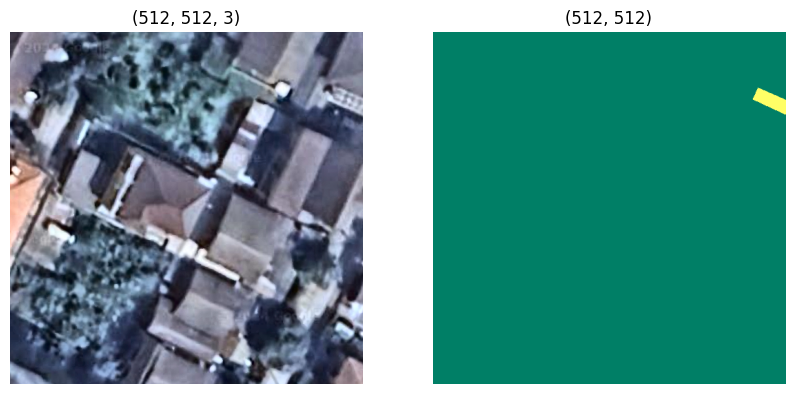

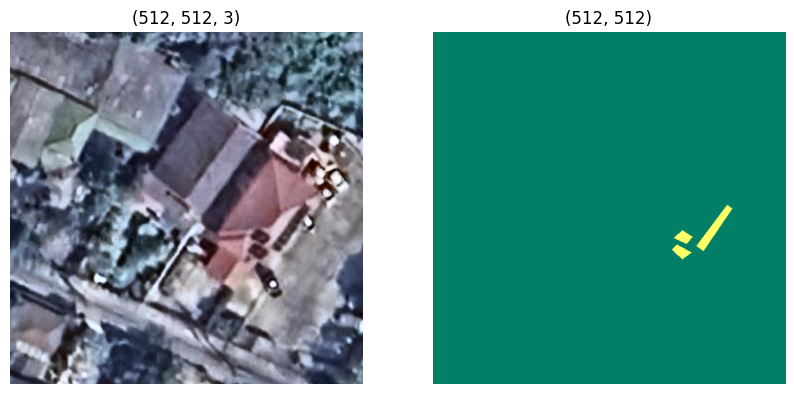

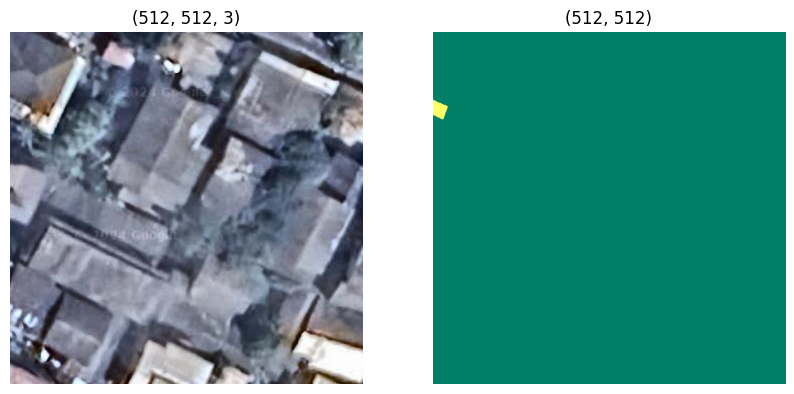

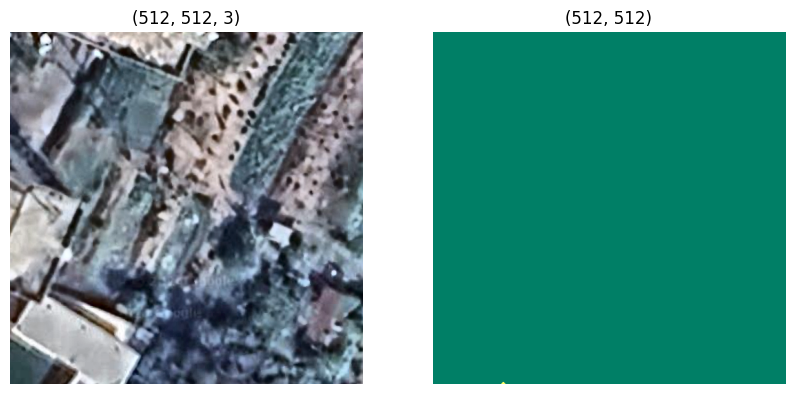

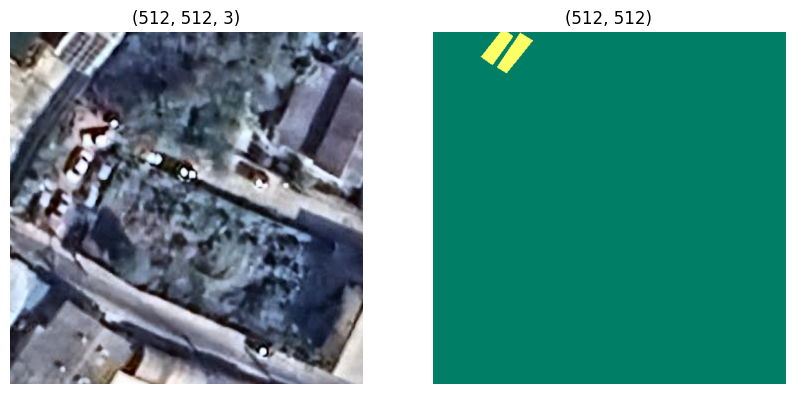

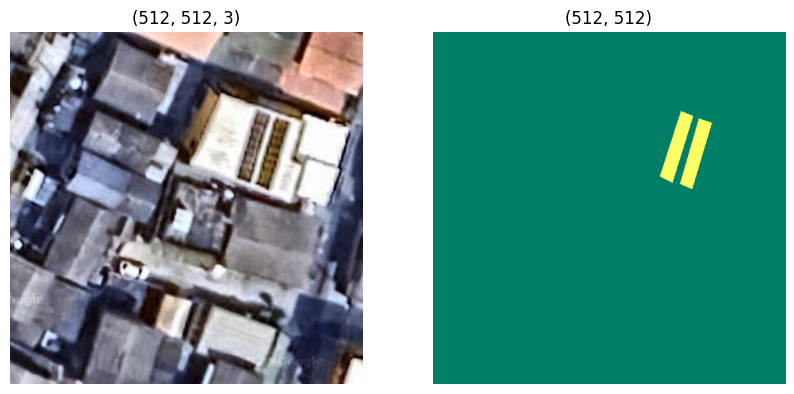

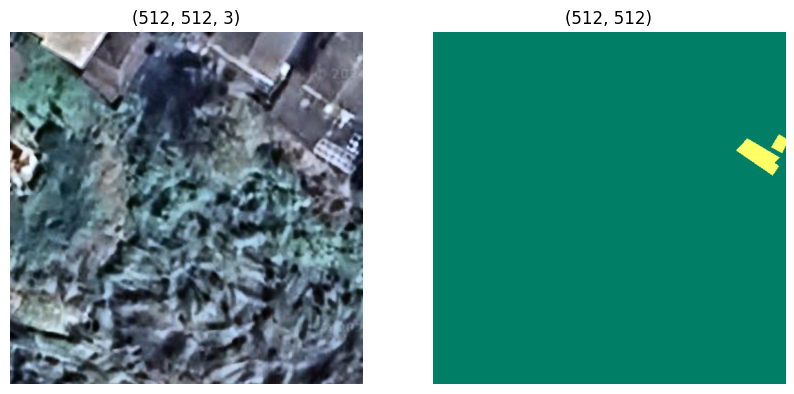

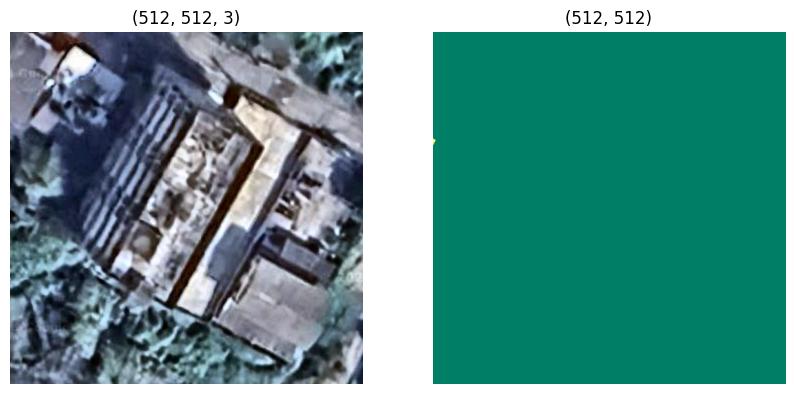

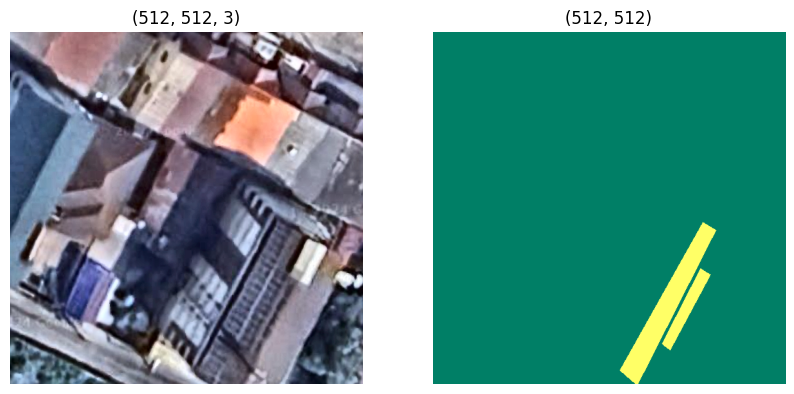

In [20]:
for item_path in image_paths:
    if '_mask' not in item_path:
        # image_path = os.path.join(root_path,item_path)
        mask_path = item_path.split('.')[0]+'_mask.png'

        image = plt.imread(item_path)
        mask = plt.imread(mask_path)
        show_images((image,mask))
